<a href="https://colab.research.google.com/github/evildead23151/UIDAI-Hackathon-Analysis/blob/main/03_multivariate_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Load Cleaned Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

BASE_IN = "/content/cleaned_outputs"

enrol_df = pd.read_csv(f"{BASE_IN}/clean_enrolment.csv")
demo_df = pd.read_csv(f"{BASE_IN}/clean_demographic_updates.csv")
bio_df = pd.read_csv(f"{BASE_IN}/clean_biometric_updates.csv")

enrol_df.shape, demo_df.shape, bio_df.shape


((117285, 7), (29898, 4), (139758, 6))

# Resolve Date Column (Reuse Robust Logic)

In [2]:
def get_date_column(df):
    candidates = [c for c in df.columns if "date" in c.lower() or "time" in c.lower()]
    col = candidates[0]
    df[col] = pd.to_datetime(df[col], errors="coerce")
    return col


In [14]:
enrol_df.columns



Index(['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17',
       'age_18_greater'],
      dtype='object')

In [15]:
demo_df.columns


Index(['Unnamed: 0', '562131', '0', '1'], dtype='object')

In [16]:
bio_df.columns

Index(['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_'], dtype='object')

In [18]:
import pandas as pd

!head -n 5 /content/cleaned_outputs/clean_demographic_updates.csv



,562131,0,1
2025-11-09,KARNATAKA,BANGALORE RURAL,562132,0,4
2025-11-09,KARNATAKA,BELAGAVI,591102,1,9
2025-11-09,KARNATAKA,BELAGAVI,591111,0,1
2025-11-09,KARNATAKA,BELAGAVI,591117,2,5


In [19]:
demo_df = pd.read_csv(
    "/content/cleaned_outputs/clean_demographic_updates.csv",
    sep="|",
    engine="python"
)

demo_df.columns


Index([',562131,0,1'], dtype='object')

In [20]:
demo_df = pd.read_csv(
    "/content/cleaned_outputs/clean_demographic_updates.csv",
    header=None,
    skiprows=1,
    names=["date", "state", "district", "pincode", "demo_val_1", "demo_val_2"]
)

demo_df.columns


Index(['date', 'state', 'district', 'pincode', 'demo_val_1', 'demo_val_2'], dtype='object')

In [21]:
demo_df["date"] = pd.to_datetime(demo_df["date"], errors="coerce")
demo_df["date"].min(), demo_df["date"].max()


(Timestamp('2025-11-09 00:00:00'), Timestamp('2025-12-09 00:00:00'))

In [22]:
demo_df.head()
demo_df.dtypes


,0
date,datetime64[ns]
state,object
district,object
pincode,float64
demo_val_1,float64
demo_val_2,float64


# Re-resolve geography columns

In [23]:
def resolve_geo_columns(df):
    state_candidates = [c for c in df.columns if "state" in c.lower()]
    district_candidates = [c for c in df.columns if "district" in c.lower()]
    return state_candidates[0], district_candidates[0]

enrol_state, enrol_district = resolve_geo_columns(enrol_df)
demo_state, demo_district = resolve_geo_columns(demo_df)
bio_state, bio_district = resolve_geo_columns(bio_df)


# Resolve numeric activity columns

In [24]:
enrol_value_cols = enrol_df.select_dtypes("number").columns
demo_value_cols = demo_df.select_dtypes("number").columns
bio_value_cols = bio_df.select_dtypes("number").columns


# Aggregate to state–district total

In [25]:
enrol_geo = (
    enrol_df
    .groupby([enrol_state, enrol_district])[enrol_value_cols]
    .sum()
    .sum(axis=1)
    .reset_index(name="enrolment_total")
)

demo_geo = (
    demo_df
    .groupby([demo_state, demo_district])[demo_value_cols]
    .sum()
    .sum(axis=1)
    .reset_index(name="demo_updates_total")
)

bio_geo = (
    bio_df
    .groupby([bio_state, bio_district])[bio_value_cols]
    .sum()
    .sum(axis=1)
    .reset_index(name="bio_updates_total")
)


In [26]:
enrol_geo.head(), demo_geo.head(), bio_geo.head()


(                         state       district  enrolment_total
 0                       100000         100000         400006.0
 1    ANDAMAN & NICOBAR ISLANDS       ANDAMANS        5208738.0
 2    ANDAMAN & NICOBAR ISLANDS       NICOBARS         744302.0
 3    ANDAMAN & NICOBAR ISLANDS  SOUTH ANDAMAN        5209049.0
 4  ANDAMAN AND NICOBAR ISLANDS        NICOBAR        5954440.0,
                          state                  district  demo_updates_total
 0    ANDAMAN & NICOBAR ISLANDS                  ANDAMANS           2232318.0
 1    ANDAMAN & NICOBAR ISLANDS             SOUTH ANDAMAN           2232518.0
 2  ANDAMAN AND NICOBAR ISLANDS                   NICOBAR           2977219.0
 3  ANDAMAN AND NICOBAR ISLANDS  NORTH AND MIDDLE ANDAMAN           2976819.0
 4  ANDAMAN AND NICOBAR ISLANDS             SOUTH ANDAMAN           7441264.0,
                          state                  district  bio_updates_total
 0    ANDAMAN & NICOBAR ISLANDS                  ANDAMANS         104

# Merge into a single multivariate dataset

In [27]:
geo_merged = (
    enrol_geo
    .merge(demo_geo, on=[enrol_state, enrol_district], how="left")
    .merge(bio_geo, on=[enrol_state, enrol_district], how="left")
)

geo_merged = geo_merged.fillna(0)
geo_merged.head()


,state,district,enrolment_total,demo_updates_total,bio_updates_total
0,100000,100000,400006.0,0.0,0.0
1,ANDAMAN & NICOBAR ISLANDS,ANDAMANS,5208738.0,2232318.0,10418561.0
2,ANDAMAN & NICOBAR ISLANDS,NICOBARS,744302.0,0.0,744302.0
3,ANDAMAN & NICOBAR ISLANDS,SOUTH ANDAMAN,5209049.0,2232518.0,744104.0
4,ANDAMAN AND NICOBAR ISLANDS,NICOBAR,5954440.0,2977219.0,16375681.0


# Behavioural ratios (high-signal features)

In [28]:
geo_merged["demo_to_enrol_ratio"] = (
    geo_merged["demo_updates_total"] /
    geo_merged["enrolment_total"].replace(0, np.nan)
)

geo_merged["bio_to_enrol_ratio"] = (
    geo_merged["bio_updates_total"] /
    geo_merged["enrolment_total"].replace(0, np.nan)
)

geo_merged = geo_merged.replace([np.inf, -np.inf], np.nan).fillna(0)

geo_merged.describe()


,enrolment_total,demo_updates_total,bio_updates_total,demo_to_enrol_ratio,bio_to_enrol_ratio
count,9.880000e+02,9.880000e+02,9.880000e+02,988.000000,988.000000
mean,6.207845e+07,1.604852e+07,7.386020e+07,0.337998,1.219110
std,7.397476e+07,2.001292e+07,9.498405e+07,0.654014,0.988656
min,1.241030e+05,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.183815e+07,3.184514e+06,1.306731e+07,0.173832,0.851972
50%,3.591359e+07,8.335698e+06,3.981407e+07,0.229632,1.053921
75%,8.307439e+07,2.122160e+07,9.419774e+07,0.333334,1.414199
max,5.953969e+08,1.453857e+08,6.608048e+08,13.995024,18.003409


# Correlation structure (justify dimensionality reduction)

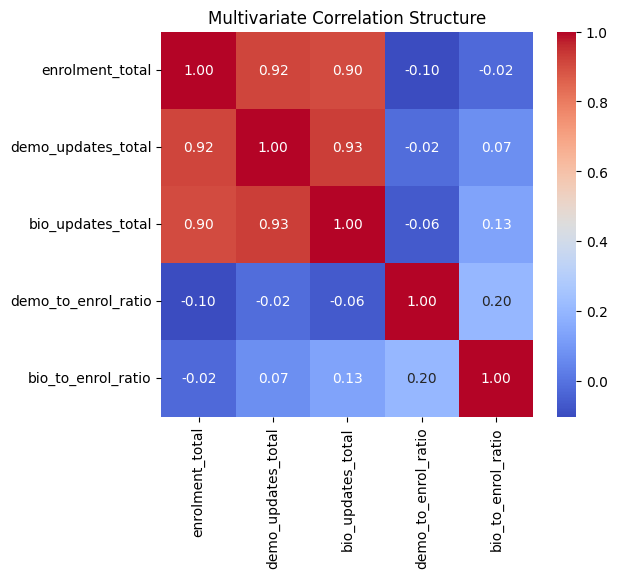

In [29]:
feature_cols = [
    "enrolment_total",
    "demo_updates_total",
    "bio_updates_total",
    "demo_to_enrol_ratio",
    "bio_to_enrol_ratio"
]

corr = geo_merged[feature_cols].corr()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Multivariate Correlation Structure")
plt.show()


# PCA (latent behavioural axes)

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = geo_merged[feature_cols]
X_scaled = StandardScaler().fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

pca.explained_variance_ratio_.cumsum()


array([0.56862626, 0.81087129, 0.96978759, 0.98676358, 1.        ])

# PCA loadings (interpretability)

In [31]:
pca_loadings = pd.DataFrame(
    pca.components_.T,
    index=feature_cols,
    columns=[f"PC{i+1}" for i in range(len(feature_cols))]
)

pca_loadings


,PC1,PC2,PC3,PC4,PC5
enrolment_total,0.572277,-0.080575,0.083208,0.797293,-0.152989
demo_updates_total,0.577835,0.035775,0.071899,-0.271780,0.765371
bio_updates_total,0.577407,0.043245,-0.030280,-0.526267,-0.621979
demo_to_enrol_ratio,-0.051165,0.697081,0.712848,0.022631,-0.052884
bio_to_enrol_ratio,0.050878,0.710237,-0.691982,0.113973,0.033866


# Save multivariate outputs

In [33]:
geo_merged.to_csv("/content/geo_multivariate_features.csv", index=False)
pca_loadings.to_csv("/content/pca_feature_loadings.csv")
